# INSTALL DEPENDENCIES

In [2]:
!pip install -qU transformers sentence-transformers datasets faiss-cpu pandas nltk scikit-learn evaluate python-terrier gradio matplotlib seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [3]:
import os
import re
import shutil
import time
import itertools as it
import warnings

import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyterrier as pt
import seaborn as sns
import torch
import torch.nn as nn
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoModel, AutoTokenizer
from IPython.display import display

warnings.filterwarnings("ignore")

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
if not pt.java.started():
    pt.init()

terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-assemblies/5.11/terrier-assemblies-5.11-jar-with-dependenci…

Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-python-helper/0.0.8/terrier-python-helper-0.0.8.jar:   0%| …

Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipython-input-4-2059753628.py:2: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


# CONFIGURATION & CONSTANTS


## Data & Evaluation Parameters

In [5]:
DOC_SUBSET_SIZE = 50000
QUERY_SUBSET_SIZE_EVAL = 50
CANDIDATES_FOR_RERANK_DEMO = 20
CANDIDATES_FOR_RERANK_MONOBERT_EVAL = 100
CANDIDATES_FOR_RERANK_DUOBERT_EVAL = 100
INDEX_PATH = "./vaswani_index_final"

## Neural Query Expander Parameters

In [6]:
NQE_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
NQE_NUM_EXP_DOCS = 5
NQE_EXP_TERMS_COUNT = 3
NQE_MAX_CANDIDATE_TERMS = 50

## BERT Re-ranker Parameters

In [7]:
BERT_MODEL_NAME = 'bert-base-uncased'
MONOBERT_BATCH_SIZE = 16
MONOBERT_MAX_LENGTH = 256
DUOBERT_BATCH_SIZE = 4
DUOBERT_MAX_LENGTH = 384

# Data Loading

In [8]:
print("--- Loading and Preparing Vaswani Dataset ---")
dataset = pt.get_dataset('irds:vaswani')

print("Loading full corpus using get_corpus_iter()...")
corpus_list = list(dataset.get_corpus_iter())
documents_df_full = pd.DataFrame(corpus_list)

documents_df_full['docno'] = documents_df_full['docno'].astype(str)
documents_df_full = documents_df_full[['docno', 'text']]


documents_df = documents_df_full.head(DOC_SUBSET_SIZE).copy()
print(f"Loaded and subsetted to {len(documents_df)} documents.")

queries_df_full = dataset.get_topics()
qrels_df_full = dataset.get_qrels()

loaded_docnos = set(documents_df['docno'].unique())

qrels_df_subset = qrels_df_full[qrels_df_full['docno'].isin(loaded_docnos)].copy()

valid_qids_in_subset = qrels_df_subset['qid'].unique()

queries_df_subset = queries_df_full[queries_df_full['qid'].isin(valid_qids_in_subset)].copy()



eval_qids = queries_df_subset['qid'].unique()[:QUERY_SUBSET_SIZE_EVAL]
eval_queries_df = queries_df_subset[queries_df_subset['qid'].isin(eval_qids)].copy()
eval_qrels_df = qrels_df_subset[qrels_df_subset['qid'].isin(eval_qids)].copy()


print(f"Prepared {len(eval_queries_df)} queries for evaluation.")
print(f"Prepared {len(eval_qrels_df)} relevance judgments (qrels) for the evaluation subset.")


print("\nSample Document (subset):")
display(documents_df.head(1))
print("\nSample Evaluation Query:")
display(eval_queries_df.head(1))
print("\nSample Evaluation Qrels:")
display(eval_qrels_df.head(1))

--- Loading and Preparing Vaswani Dataset ---
Loading full corpus using get_corpus_iter()...


vaswani documents:   0%|          | 0/11429 [00:00<?, ?it/s]

[INFO] [starting] http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz

http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz: 0.0%| 0.00/2.13M [00:00<?, ?B/s]
http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz: 2.3%| 49.2k/2.13M [00:00<00:07, 261kB/s]
http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz: 7.3%| 156k/2.13M [00:00<00:04, 410kB/s] 
http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz: 19.3%| 410k/2.13M [00:00<00:02, 850kB/s]
http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz: 39.7%| 844k/2.13M [00:00<00:00, 1.43MB/s]
http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz: 96.0%| 2.04M/2.13M [00:00<00:00, 2.96MB/s]
[INFO] [finished] http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz: [00:00] [2.13MB] [3.06MB/s]

http://ir.dcs.gla.ac.uk/resources/test_collections/npl/npl.tar.gz: [00:00] [2.13MB] [3.00MB/s]
                                                               

Loaded and subsetted to 11429 documents.
Prepared 50 queries for evaluation.
Prepared 1208 relevance judgments (qrels) for the evaluation subset.

Sample Document (subset):


,docno,text
0,1,compact memories have flexible capacities a d...



Sample Evaluation Query:


,qid,query
0,1,measurement of dielectric constant of liquids ...



Sample Evaluation Qrels:


,qid,docno,label,iteration
0,1,1239,1,0


# Text Processing & Indexing

In [9]:
nltk_stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text: str) -> str:
    """Cleans, tokenizes, stems, and removes stopwords from text."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    processed_tokens = [stemmer.stem(w) for w in tokens if w not in nltk_stop_words]
    return ' '.join(processed_tokens)

print("Preprocessing document text...")
documents_df['processed_text'] = documents_df['text'].apply(preprocess_text)

index_data = pd.DataFrame({
    'docno': documents_df['docno'].astype(str),
    'text': documents_df['processed_text']
})

print("\nValidating DataFrame...")
print(f"Columns: {list(index_data.columns)}")
print(f"Sample data:\n{index_data.head(2)}")
if index_data['docno'].isnull().any() or index_data['text'].isnull().any():
    raise ValueError("Null values in 'docno' or 'text' columns")

if os.path.exists(INDEX_PATH):
    shutil.rmtree(INDEX_PATH)

print("\nBuilding index...")
pt.set_property('indexer.meta.forward.keys', 'docno,text')
pt.set_property('indexer.meta.forward.keylens', '100,4096')
pt.set_property('indexer.meta.reverse.keys', 'docno')
pt.set_property('metaindex.compressed.reverse.allow.duplicates', 'true')

indexer = pt.DFIndexer(INDEX_PATH, overwrite=True, verbose=True)
index_ref = indexer.index(index_data['text'], index_data['docno'])
index = pt.IndexFactory.of(index_ref)
print("\nIndex built successfully! Collection Statistics:")
print(index.getCollectionStatistics())

Preprocessing document text...

Validating DataFrame...
Columns: ['docno', 'text']
Sample data:
  docno                                               text
0     1  compact memori flexibl capac digit data storag...
1     2  electron analogu comput solv system linear equ...

Building index...


  0%|          | 0/11429 [00:00<?, ?documents/s]


Index built successfully! Collection Statistics:
Number of documents: 11429
Number of terms: 7706
Number of postings: 226290
Number of fields: 0
Number of tokens: 273326
Field names: []
Positions:   false



# Transformer Classes


In [10]:
class EmbeddingQueryExpansionTransformer(pt.Transformer):
    """Expands a query using terms from top-retrieved documents based on embedding similarity."""
    def __init__(self, first_pass_retriever, docs_df, model_name, num_docs, num_terms, max_candidates):
        self.retriever, self.docs_df = first_pass_retriever, docs_df
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = _get_nqe_model(model_name, self.device)
        self.num_docs, self.num_terms, self.max_candidates = num_docs, num_terms, max_candidates
        self.last_expanded_query = ""
    def _expand(self, query, top_docs_texts):
        if not top_docs_texts: return query
        query_emb = self.model.encode([query], convert_to_tensor=True, show_progress_bar=False)[0]
        doc_text = ' '.join(filter(None, top_docs_texts));
        if not doc_text.strip(): return query
        tokens = list(set(t for t in word_tokenize(doc_text.lower()) if t.isalpha() and t not in nltk_stop_words))
        candidate_tokens = [t for t in tokens if t not in query.lower()][:self.max_candidates]
        if not candidate_tokens: return query
        term_embs = self.model.encode(candidate_tokens, convert_to_tensor=True, show_progress_bar=False)
        if term_embs.nelement() == 0: return query
        sims = cosine_similarity(query_emb.unsqueeze(0).cpu().numpy(), term_embs.cpu().numpy())[0]
        expanded_terms = [candidate_tokens[i] for i in np.argsort(sims)[-self.num_terms:]]
        return query + ' ' + ' '.join(expanded_terms)
    def transform(self, topics):
        first_pass = self.retriever.transform(topics.copy())
        expanded_queries = []
        for qid, group in topics.groupby('qid'):
            orig_query = group['query'].iloc[0]
            docnos = first_pass[first_pass['qid'] == qid].head(self.num_docs)['docno'].tolist()
            doc_texts = self.docs_df[self.docs_df['docno'].isin(docnos)]['text'].tolist()
            expanded_query = self._expand(orig_query, doc_texts)
            self.last_expanded_query = expanded_query
            new_row = group.iloc[[0]].copy(); new_row['query'] = expanded_query
            expanded_queries.append(new_row)
        return pd.concat(expanded_queries, ignore_index=True) if expanded_queries else topics

class MonoBERTReranker(pt.Transformer):
    """Re-ranks documents using a MonoBERT cross-encoder."""
    def __init__(self, docs_df, model_name, batch_size, max_length):
        self.docs_df, self.device = docs_df, "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.tokenizer, self.linear = _get_model_and_tokenizer(model_name, self.device, "mono")
        self.batch_size, self.max_length = batch_size, max_length
    def transform(self, inp_df):
        results = []
        for qid, group in inp_df.groupby('qid'):
            query, docnos = group['query'].iloc[0], group['docno'].tolist()
            doc_texts = [self.docs_df.loc[self.docs_df['docno'] == d, 'text'].iloc[0] for d in docnos]
            scores = np.zeros(len(docnos))
            with torch.no_grad():
                for i in range(0, len(docnos), self.batch_size):
                    inputs = self.tokenizer([query]*len(doc_texts[i:i+self.batch_size]), doc_texts[i:i+self.batch_size], return_tensors='pt', truncation='longest_first', padding='max_length', max_length=self.max_length).to(self.device)
                    cls_emb = self.model(**inputs).last_hidden_state[:, 0, :]
                    scores[i:i+len(inputs['input_ids'])] = self.linear(cls_emb).squeeze(-1).cpu().numpy()
            res_group = group.copy(); res_group['score'] = scores
            results.append(res_group)
        return pd.concat(results).sort_values(['qid', 'score'], ascending=[True, False]) if results else inp_df

class DuoBERTReranker(pt.Transformer):
    """Re-ranks documents using a DuoBERT pairwise approach."""
    def __init__(self, docs_df, model_name, batch_size, max_length):
        self.docs_df, self.device = docs_df, "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.tokenizer, self.linear = _get_model_and_tokenizer(model_name, self.device, "duo")
        self.batch_size, self.max_length = batch_size, max_length
    def transform(self, inp_df):
        results = []
        for qid, group in inp_df.groupby('qid'):
            query, docnos = group['query'].iloc[0], group['docno'].tolist()
            docs = [self.docs_df.loc[self.docs_df['docno'] == d, 'text'].iloc[0] for d in docnos]
            if len(docs) < 2:
                res_group = group.copy(); res_group['score'] = 0.0; results.append(res_group); continue
            prefs, pairs = {dn: 0 for dn in docnos}, []
            for i in range(len(docs)):
                for j in range(i + 1, len(docs)):
                    pairs.extend([f"{query} [SEP] {docs[i]} [SEP] {docs[j]}", f"{query} [SEP] {docs[j]} [SEP] {docs[i]}"])
            if not pairs: results.append(group); continue
            all_logits = []
            with torch.no_grad():
                for i in range(0, len(pairs), self.batch_size):
                    inputs = self.tokenizer(pairs[i:i+self.batch_size], return_tensors='pt', truncation='longest_first', padding='max_length', max_length=self.max_length).to(self.device)
                    all_logits.extend(self.linear(self.model(**inputs).last_hidden_state[:, 0, :]).squeeze(-1).cpu().numpy())
            ptr = 0
            for i in range(len(docs)):
                for j in range(i + 1, len(docs)):
                    if ptr + 1 < len(all_logits):
                        score_di_dj, score_dj_di = all_logits[ptr], all_logits[ptr+1]
                        if score_di_dj > score_dj_di: prefs[docnos[i]] += 1
                        else: prefs[docnos[j]] += 1
                        ptr += 2
            res_group = group.copy(); res_group['score'] = [float(prefs[dn]) for dn in docnos]
            results.append(res_group)
        return pd.concat(results).sort_values(['qid', 'score'], ascending=[True, False]) if results else inp_df

# Model & Pipeline Definitions

In [11]:
_nqe_model_instance = None
_monobert_model_tokenizer = None
_duobert_model_tokenizer = None

def _get_model_and_tokenizer(model_name, device, model_type="mono"):
    global _monobert_model_tokenizer, _duobert_model_tokenizer
    target_cache = _monobert_model_tokenizer if model_type == "mono" else _duobert_model_tokenizer
    if target_cache is None:
        print(f"Loading {model_type.capitalize()}BERT model: {model_name}...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(device).eval()
        linear_layer = nn.Linear(model.config.hidden_size, 1).to(device).eval()
        cache_tuple = (model, tokenizer, linear_layer)
        if model_type == "mono": _monobert_model_tokenizer = cache_tuple
        else: _duobert_model_tokenizer = cache_tuple
        return cache_tuple
    return target_cache

def _get_nqe_model(model_name, device):
    global _nqe_model_instance
    if _nqe_model_instance is None:
        print(f"Loading NQE model: {model_name}...")
        _nqe_model_instance = SentenceTransformer(model_name, device=device)
    return _nqe_model_instance



print("--- Assembling Retrieval Pipelines ---")

tfidf_retriever = pt.BatchRetrieve(index, wmodel="TF_IDF", verbose=False)
bm25_retriever = pt.BatchRetrieve(index, wmodel="BM25", verbose=False)

rm3_expander = pt.rewrite.RM3(index, fb_terms=10, fb_docs=3)
bm25_rm3_pipeline = bm25_retriever >> rm3_expander >> bm25_retriever

nqe_transformer = EmbeddingQueryExpansionTransformer(bm25_retriever % (NQE_NUM_EXP_DOCS * 2), documents_df, NQE_MODEL_NAME, NQE_NUM_EXP_DOCS, NQE_EXP_TERMS_COUNT, NQE_MAX_CANDIDATE_TERMS)
bm25_nqe_pipeline = nqe_transformer >> bm25_retriever

mono_reranker = MonoBERTReranker(documents_df, BERT_MODEL_NAME, MONOBERT_BATCH_SIZE, MONOBERT_MAX_LENGTH)
duo_reranker = DuoBERTReranker(documents_df, BERT_MODEL_NAME, DUOBERT_BATCH_SIZE, DUOBERT_MAX_LENGTH)


bm25_monobert_pipeline = (bm25_retriever % CANDIDATES_FOR_RERANK_MONOBERT_EVAL) >> mono_reranker
bm25_duobert_pipeline = (bm25_retriever % CANDIDATES_FOR_RERANK_DUOBERT_EVAL) >> duo_reranker

pipelines_to_evaluate = [
    tfidf_retriever,
    bm25_retriever,
    bm25_rm3_pipeline,
    bm25_nqe_pipeline,
    bm25_monobert_pipeline,
    bm25_duobert_pipeline
]

pipeline_names = [
    "TF-IDF (Baseline)",
    "BM25",
    "BM25 + RM3",
    "BM25 + Neural QE",
    f"BM25 >> MonoBERT (Top {CANDIDATES_FOR_RERANK_MONOBERT_EVAL})",
    f"BM25 >> DuoBERT (Top {CANDIDATES_FOR_RERANK_DUOBERT_EVAL})"
]

--- Assembling Retrieval Pipelines ---
Loading NQE model: sentence-transformers/all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading MonoBERT model: bert-base-uncased...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading DuoBERT model: bert-base-uncased...


# System Evaluation

In [12]:
print("--- Running System Evaluation ---")
experiment_results = pt.Experiment(
    pipelines_to_evaluate,
    eval_queries_df,
    eval_qrels_df,
    eval_metrics=["map", "ndcg", "P_10"],
    names=pipeline_names,
    baseline=0
)

print("\nEvaluation Complete. Results Table:")
display(experiment_results)

--- Running System Evaluation ---

Evaluation Complete. Results Table:


,name,map,P_10,ndcg,map +,map -,map p-value,P_10 +,P_10 -,P_10 p-value,ndcg +,ndcg -,ndcg p-value
0,TF-IDF (Baseline),0.313446,0.380,0.630377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25,0.313763,0.380,0.631876,25.0,23.0,8.009063e-01,1.0,1.0,1.000000e+00,26.0,22.0,2.413605e-01
2,BM25 + RM3,0.314884,0.366,0.632246,29.0,19.0,8.366055e-01,9.0,10.0,3.674076e-01,31.0,17.0,7.553951e-01
3,BM25 + Neural QE,0.275832,0.332,0.605808,17.0,32.0,5.893028e-03,7.0,17.0,1.085188e-02,21.0,28.0,3.485302e-02
4,BM25 >> MonoBERT (Top 100),0.121925,0.158,0.354376,6.0,43.0,4.042006e-11,5.0,39.0,3.561746e-09,2.0,47.0,2.808306e-18
5,BM25 >> DuoBERT (Top 100),0.112322,0.148,0.343758,3.0,46.0,1.972461e-11,3.0,41.0,3.432456e-10,2.0,47.0,9.617287e-18


# Results Analysis: Quantifying Improvement

--- Quantitative Improvement Analysis ---
Comparing all models against the baseline: 'TF-IDF (Baseline)'

                     Model MAP vs Baseline NDCG vs Baseline P_10 vs Baseline
                      BM25          +0.10%           +0.24%           +0.00%
                BM25 + RM3          +0.46%           +0.30%           -3.68%
          BM25 + Neural QE         -12.00%           -3.90%          -12.63%
BM25 >> MonoBERT (Top 100)         -61.10%          -43.78%          -58.42%
 BM25 >> DuoBERT (Top 100)         -64.17%          -45.47%          -61.05%


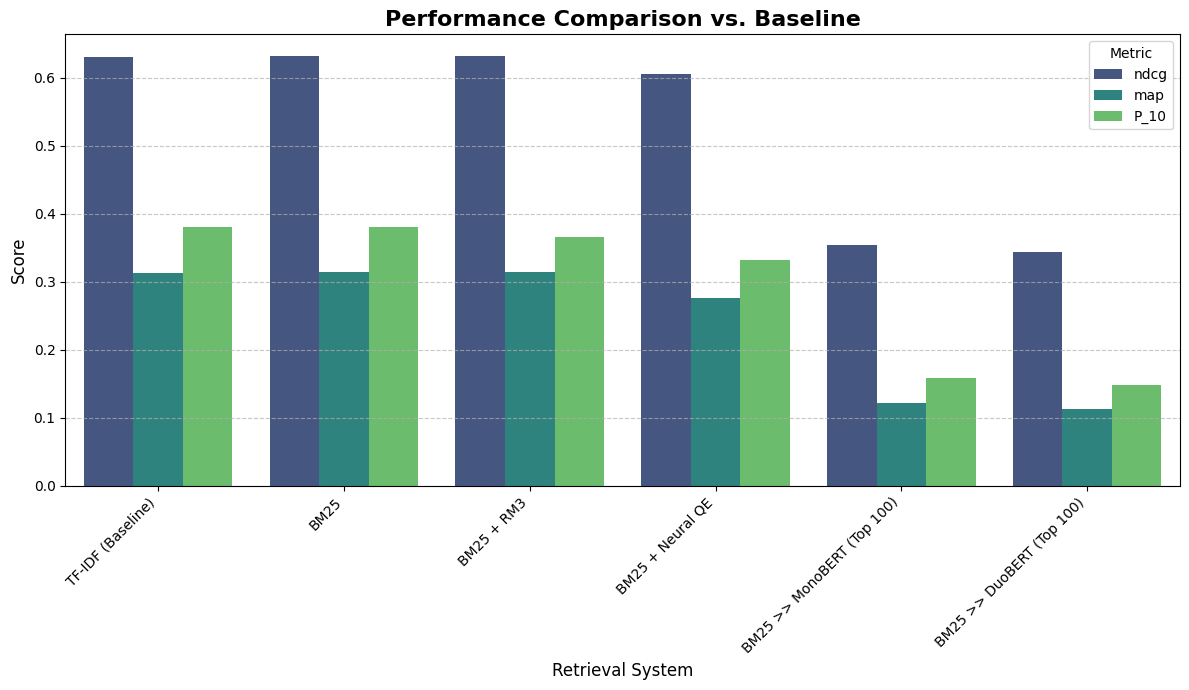

In [13]:
print("--- Quantitative Improvement Analysis ---")
baseline_row = experiment_results.iloc[0]
baseline_name = baseline_row['name']
print(f"Comparing all models against the baseline: '{baseline_name}'\n")

summary_data = []
for i, row in experiment_results.iloc[1:].iterrows():
    improvements = {}
    for metric in ['map', 'ndcg', 'P_10']:
        baseline_score, model_score = baseline_row[metric], row[metric]
        if baseline_score > 0:
            improvement = ((model_score - baseline_score) / baseline_score) * 100
            improvements[f'{metric.upper()} vs Baseline'] = f"{improvement:+.2f}%"
        else:
            improvements[f'{metric.upper()} vs Baseline'] = "N/A (baseline is 0)"

    summary_data.append({"Model": row['name'], **improvements})

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Visual Comparison
plot_data = experiment_results.melt(id_vars=['name'], value_vars=['ndcg', 'map', 'P_10'], var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 7))
sns.barplot(data=plot_data, x='name', y='Score', hue='Metric', palette='viridis')
plt.title('Performance Comparison vs. Baseline', fontsize=16, weight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Retrieval System', fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#  Interactive Demonstration (Gradio)

In [14]:
def launch_gradio_demo(pipelines_dict, documents_df):
    """Sets up and launches the Gradio interactive interface."""
    def format_results_for_gradio(results_df, top_n):
        if results_df.empty: return pd.DataFrame()
        output_data = []
        for i, row in results_df.head(int(top_n)).iterrows():
            docno, score = str(row['docno']), row.get('score', 'N/A')
            rank = i + 1
            snippet = documents_df[documents_df['docno'] == docno]['text'].iloc[0][:250] + "..."
            score_str = f"{score:.4f}" if isinstance(score, (float, np.floating)) else str(score)
            output_data.append({"Rank": rank, "DocID": docno, "Score": score_str, "Content Snippet": snippet})
        return pd.DataFrame(output_data)

    def create_score_plot(results_df, top_n):
        fig = plt.figure(figsize=(8, 4))
        if results_df.empty or 'score' not in results_df.columns:
            plt.text(0.5, 0.5, "No scores to plot.", ha='center'); plt.axis('off'); return fig
        top_results = results_df.head(int(top_n)).copy()
        top_results['score'] = pd.to_numeric(top_results['score'], errors='coerce')
        sns.barplot(x=range(1, len(top_results) + 1), y='score', data=top_results, palette="viridis")
        plt.title(f'Top {len(top_results)} Score Distribution'); plt.xlabel('Rank'); plt.ylabel('Score')
        plt.tight_layout(); return fig

    def search_interface(query, system_name, top_n):
        if not query: return pd.DataFrame(), "Please enter a query.", "0.00s", None
        pipeline = pipelines_dict[system_name]
        search_df = pd.DataFrame([{'qid': 'g1', 'query': query}])
        start_time = time.time()
        results_df = pipeline.transform(search_df)
        time_str = f"{(time.time() - start_time):.2f}s"
        status = f"Displaying top {min(int(top_n), len(results_df))} results."
        return format_results_for_gradio(results_df, top_n), status, time_str, create_score_plot(results_df, top_n)

    with gr.Blocks(theme=gr.themes.Soft(primary_hue="teal", secondary_hue="cyan")) as demo:
        gr.Markdown("# 📊 CORD-19 Interactive Information Retrieval System")
        with gr.Row():
            query_input = gr.Textbox(label="Query", placeholder="e.g., long term effects of coronavirus", scale=3)
            system_selector = gr.Dropdown(label="Retrieval System", choices=list(pipelines_dict.keys()), value=list(pipelines_dict.keys())[0], scale=2)
            top_n_slider = gr.Slider(minimum=1, maximum=CANDIDATES_FOR_RERANK_DEMO, value=5, step=1, label="Top N Results", scale=1)
        search_btn = gr.Button("Search & Visualize 📈", variant="primary")
        with gr.Row():
            status_box = gr.Textbox(label="Status", interactive=False, scale=2)
            time_box = gr.Textbox(label="Query Time", interactive=False, scale=1)
        with gr.Row():
            results_table = gr.DataFrame(headers=["Rank", "DocID", "Score", "Content Snippet"], label="Ranked Documents", wrap=True)
            score_plot = gr.Plot(label="Score Distribution")
        search_btn.click(search_interface, [query_input, system_selector, top_n_slider], [results_table, status_box, time_box, score_plot])
        gr.Examples([["effectiveness of masks", "BM25 + RM3", 5],["long term effects of coronavirus", f"BM25 >> MonoBERT (Top {CANDIDATES_FOR_RERANK_DEMO})", 5]], [query_input, system_selector, top_n_slider])

    demo.launch(debug=True, share=True)

pipelines_demo_dict = dict(zip(pipeline_names, pipelines_to_evaluate))